In [17]:
# Connexion
import mysql.connector
import sys

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
from nltk import *
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #pour pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

import pickle

[nltk_data] Downloading package omw-1.4 to C:\Users\Admin\Documents\ma
[nltk_data]     rianneSimplon\simplon\sentiment_analysis_virtual\env\l
[nltk_data]     ib\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Admin\Documents\ma
[nltk_data]     rianneSimplon\simplon\sentiment_analysis_virtual\env\l
[nltk_data]     ib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to C:\Users
[nltk_data]     \Admin\Documents\marianneSimplon\simplon\sentiment_ana
[nltk_data]     lysis_virtual\env\lib\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def connect():
    try:
        cnx = mysql.connector.connect(host="localhost",user="root",password="root",auth_plugin='mysql_native_password',database="sentiment_analysis")
    except mysql.connector.Error as err:
        cnx = False
        print(err)
        sys.exit(1)
    finally:
        return cnx

In [3]:
conn = connect()
conn
cursor = conn.cursor()

In [4]:
def create_dataframe():
    cursor.execute("""  SELECT *
                    FROM clothing_reviews; """)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows,columns=['Index','Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'])
    df = df.set_index('Index')
    df = df.replace('',np.nan,regex = True)
    return df

In [5]:
df_ori = create_dataframe()

# Cleaning

In [6]:
#Suppression de 845 données car il nous faut absolument TOUTES les Review Text
df_ori.dropna(subset=['Review Text'], inplace=True)
# df_ori.isna().sum()

In [7]:
df = df_ori[["Review Text","Recommended IND"]]

In [8]:
stop_words = stopwords.words('english')

In [9]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

In [10]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. Lemmatize
    POS_tagging = pos_tag(tokens_without_sw)
    wordnet_pos_tag=[]
    wordnet_pos_tag = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in POS_tagging]
    wnl = WordNetLemmatizer()
    lemma = [wnl.lemmatize(word, tag) for word, tag in wordnet_pos_tag]
    
    return " ".join(lemma)

In [11]:
df['Document'] = df['Review Text'].apply(cleaning)
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_209716\4105619847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Document'] = df['Review Text'].apply(cleaning)


,Review Text,Recommended IND,Document
Index,,,
1,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
2,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happen find store im gl...
3,I had such high hopes for this dress and reall...,0,high hope dress really wanted work initially o...
4,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...
5,This shirt is very flattering to all due to th...,1,shirt flatter due adjustable front tie perfect...
...,...,...,...
23482,I was very happy to snag this dress at such a ...,1,happy snag dress great price easy slip flatter...
23483,"It reminds me of maternity clothes. soft, stre...",1,reminds maternity clothes soft stretchy shiny ...
23484,"This fit well, but the top was very see throug...",0,fit well top see never would work im glad able...


In [12]:
# df.to_csv('./datasets/df_cleaned.csv')

# Data Mining

In [21]:
X = df["Document"].values
y = df["Recommended IND"].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

##### Undersampling

In [23]:
from imblearn.under_sampling import RandomUnderSampler

In [81]:
rus = RandomUnderSampler(random_state=42,sampling_strategy=0.6)
X_rus, y_rus = rus.fit_resample(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

In [82]:
#Reshape en tableau pour passer dans le tokenizer
X_train_rus = X_rus.reshape(-1)
y_train_rus = y_rus.reshape(-1)

In [86]:
#X_rus_autoML et y_rus_autoML pour tester autoML
X_rus_autoML = np.concatenate((X_train_rus, X_test))
y_rus_autoML = np.concatenate((y_train_rus, y_test))

In [29]:
print(pd.DataFrame(y_train).value_counts())
print(pd.DataFrame(y_rus).value_counts())

1    14831
0     3281
dtype: int64
1    5468
0    3281
dtype: int64


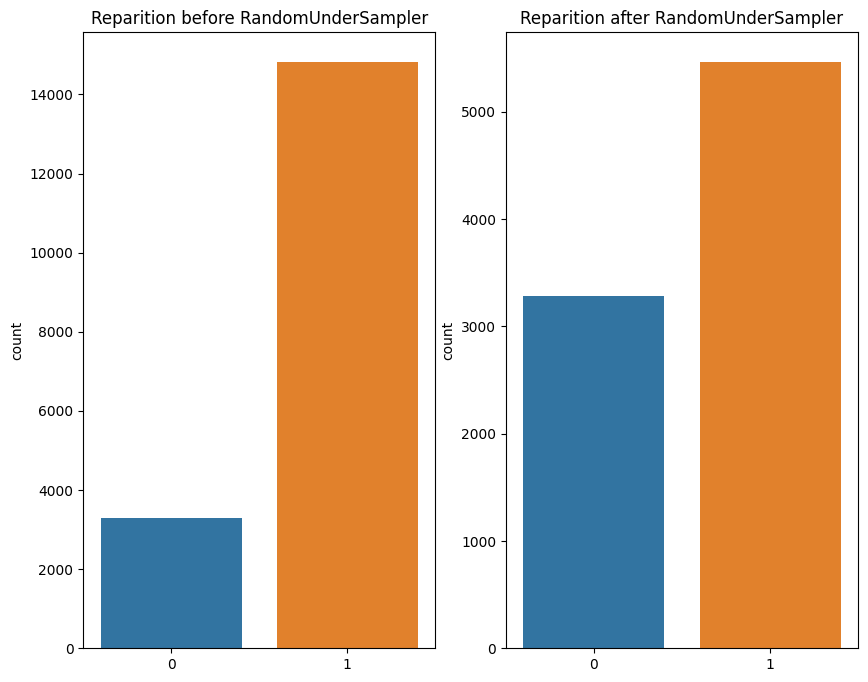

In [46]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Reparition before RandomUnderSampler')
plt.subplot(1, 2, 2)
sns.countplot(x=y_rus)
plt.title('Reparition after RandomUnderSampler')
plt.show()

In [55]:
# #Re-tokeniser
# X_train_rus_tok = word_tokenize(pd.Series(X_train_rus).replace("'", ""))
# X_train_rus_tok

In [56]:
#Parameters

# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()


In [58]:
X_train_trans = vectorizer.fit_transform(X_train_rus)
X_test_trans = vectorizer.transform(X_test)

In [60]:
X_train_trans

<8749x7512 sparse matrix of type '<class 'numpy.float64'>'
	with 223581 stored elements in Compressed Sparse Row format>

In [61]:
def save_preprocess(file_name):
    with open(f"./pickle_preprocess/{file_name}.pickle", 'wb') as handle:
        pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# save_preprocess("CountVectorizer")
# save_preprocess("TfidfVectorizer")

In [62]:
def model_evaluation(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print(confusion_matrix(y_test, y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    plot_confusion_matrix(model, X_test, y_test, cmap="plasma")

Rééquilibrage des données

Word2Vec

##### Logistic Regression

In [199]:
with open('./pickle_preprocess/TfidfVectorizer.pickle','rb') as fe_data_file:
     data = pickle.load(fe_data_file)

In [21]:
# print(data)

In [22]:
# vectorizer.inverse_transform(data)

In [ ]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000, class_weight = 'balanced', random_state = 101)
logreg.fit(X_train_count,y_train)

In [ ]:
print("LogReg_Count Model")
print ("------------------")
eval(logreg_count, X_train_count, X_test_count)

In [ ]:
#with open('model.pickle', 'wb') as handle:
#    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### XGBOOST

In [64]:
from lazypredict.Supervised import LazyClassifier

In [65]:
from sklearn.metrics import f1_score

In [93]:
clf = LazyClassifier(predictions=True,verbose=0,ignore_warnings=True,custom_metric=f1_score)
# clf = LazyClassifier(verbose=0,ignore_warnings=True)
models,predictions = clf.fit(pd.DataFrame(X_train_trans.toarray()), pd.DataFrame(X_test_trans.toarray()), y_train_rus, y_test)
models

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [56:38<00:00, 117.18s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,f1_score,Time Taken
Model,,,,,,
NearestCentroid,0.85,0.84,0.84,0.86,0.90,5.85
LGBMClassifier,0.87,0.83,0.83,0.88,0.92,14.83
BernoulliNB,0.87,0.83,0.83,0.87,0.92,6.89
XGBClassifier,0.87,0.81,0.81,0.87,0.92,133.23
ExtraTreesClassifier,0.88,0.81,0.81,0.88,0.93,107.61
RandomForestClassifier,0.88,0.80,0.80,0.88,0.93,42.46
NuSVC,0.86,0.77,0.77,0.86,0.91,770.62
AdaBoostClassifier,0.83,0.77,0.77,0.84,0.90,128.32
BaggingClassifier,0.79,0.76,0.76,0.81,0.86,94.45


In [67]:
from lazytextpredict import basic_classification

In [88]:
%%time
trial=basic_classification.LTP(Xdata=pd.Series(X_rus_autoML),Ydata=pd.Series(y_rus_autoML), models='count-vectorizer')
trial.run()

converting pandas series to list
converting pandas series to list
X_train length: 11950
X_test length: 1328
Y_train length: 11950
Y_test length: 1328


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Training on a dataset with 2 labels
ERROR
best parameters are:
{'clf__alpha': 0.001, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
{'eval_loss': 0.27936746987951805, 'eval_accuracy': 0.7206325301204819, 'eval_f1': 0.5080278195225946, 'eval_precision': 0.8232527929332294, 'eval_recall': 0.5495855252670174, 'eval_full_report': '              precision    recall  f1-score   support\n\n           0       0.93      0.10      0.18       410\n           1       0.71      1.00      0.83       918\n\n    accuracy                           0.72      1328\n   macro avg       0.82      0.55      0.51      1328\nweighted avg       0.78      0.72      0.63      1328\n'}


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Training on a dataset with 2 labels
ERROR
best parameters are:
{'clf__alpha': 0.1, 'clf__fit_prior': False, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
{'eval_loss': 0.16114457831325302, 'eval_accuracy': 0.838855421686747, 'eval_f1': 0.8187805282422109, 'eval_precision': 0.8095139464236398, 'eval_recall': 0.8335033742494287, 'eval_full_report': '              precision    recall  f1-score   support\n\n           0       0.71      0.82      0.76       410\n           1       0.91      0.85      0.88       918\n\n    accuracy                           0.84      1328\n   macro avg       0.81      0.83      0.82      1328\nweighted avg       0.85      0.84      0.84      1328\n'}
CPU times: total: 8.67 s
Wall time: 41.2 s


In [89]:
trial.print_metrics_table()

                    Model            loss        accuracy              f1       precision          recall
               linear_SVM         0.27937         0.72063         0.50803         0.82325         0.54959
multinomial_naive_bayesian         0.16114         0.83886         0.81878         0.80951          0.8335


In [90]:
%%time
trial=basic_classification.LTP(Xdata=pd.Series(X_rus_autoML),Ydata=pd.Series(y_rus_autoML), models='transformers')
trial.run()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


converting pandas series to list
converting pandas series to list
X_train length: 11950
X_test length: 1328
Y_train length: 11950
Y_test length: 1328
Training on a dataset with 2 labels


loading configuration file config.json from cache at C:\Users\Admin/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Admin/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\pytorch_model.bin
Some weights 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 11950
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3735
  Number of trainable parameters = 109483778


Step,Training Loss


KeyboardInterrupt: 

In [91]:
trial.print_metrics_table()

                    Model            loss        accuracy              f1       precision          recall
